# Calculate the GW modes for each exoplanet that has the needed parameters in the dbase.

In [1]:
# Started WEG  20180320. 
# See the gwtools.py which has utility and strain functions in it
# and ExopDBase notebook that can download a new csv exop database.

# References
P. Amaro-Seoane et al. "Triplets of supermassive black holes: astrophysics, gravitational waves and detection," MNRAS 402 2308-2320 (2010).

P. C. Peters and J. Mathews, "Gravitational Radiation from Point Masses in a Keplerian Orbit," Phys. Rev. 131 (1963) 435-440.

Michele Maggiore, "Gravitational Waves. Volume 1: Theory and Experiments," Oxford Univ. Press, 2008.

Shane Larson, "Sensitivity Curves for ..."  http://www.srl.caltech.edu/~shane/sensitivity/

Neil Cornish and Travis Robson, "The construction and use of LISA sensitivy curves," https://arxiv.org/abs/1803.01944

In [2]:
import sys, os
import numpy as np
import urllib as ul
import pandas as pd
import gwTools as gwt
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import scipy.interpolate as spint

# CalTech Exop Database (from ExopDBase notebook)

## Update or not from the CalTech database.  Directories for the dbase and to save plots.

In [3]:
thisDir = os.getcwd()  # This is the /python subdirectory.
csvDir = thisDir + '/../dbases/'  # Will the /../ work on non-Unices?
pixDir = thisDir + '/../pix/'

## Search string, might want RA and DEC also.

In [4]:
# The search URL and search string/request. 
exopURL = \
  "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-\
nstedAPI?" ;

#searchString = \
#"table=exoplanets&select=pl_hostname,ra,dec&order=dec&format=CSV";*)

# The Below does NOT have right ascension and declination.  Will likely want them for further work.
# Can add later in its own Panda dataframe and/or merge into the main one in GWStrainPlotsSNR.
# variables come from NASA Exoplanet Archive, the keywords are defined here: 
#https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html 
searchString = \
  "table=exoplanets&select=pl_hostname,pl_letter,pl_discmethod,pl_\
orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_\
plx&order=dec&format=CSV";

## Flags for fresh import and for saving the CSV file.

In [5]:
# Set to True to re-read the EXop Dbase from Caltech.  False to use csvFname below.
newImport = False;
#newImport = False;
saveFile = True;# Future work, when we do NOT want an intermediate file here would set to False, but needs coding.
#saveFile = False;

In [6]:
# csv file below was downloaded earlier with code below.  newImport = False to use it.  Or new csv will be
# created.  This takes a few seconds.
csvFileName = csvDir + 'exopP_20180518_173344.csv' 
if newImport and saveFile:
    myDateTimeStamp = gwt.dateTimeStamp()  # See the gwtools.py file with this and other functions in it.
    csvFileName = csvDir + 'exopP_' + myDateTimeStamp + '.csv'
    ofile = open(csvFname, 'w')
    with ul.request.urlopen(exopURL + searchString) as response:
        for aline in response:
            ofile.write( aline.decode('utf-8') )  # byte-string needs to be decoded. utf-8 is common encoding
    ofile.close()
    print('Saved database file ' + csvFileName)


## Read the CSV file and drop the rows/exops with NaN in the important fields.  See ExopDBase.ipynb and re-run it for updating the dbase.

In [7]:
print('Using database file ' + csvFileName)
with open(csvFileName, 'r') as ifile:
    print(ifile.readline(), '\n', ifile.readline() )  #Print a couple of lines and reset the pointer.

    ifile.seek(0);

    dbData = pd.read_csv(ifile)  # Read in the whole file to a Panda Dataframe, handles NaN's nicely, see below.
    #ifile.close()  # Should close when you leave the "with."

Using database file /home/gabella/Documents/astro/exop/exoplanetsMath/python/../dbases/exopP_20180518_173344.csv
pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx
 
 HD 142022 A,b,Radial Velocity,1928.00000000,2.930000,0.530000,4.44000,35.87,0.90,2018-04-26,27.88



In [8]:
dbData.head(10)  # NaN's show up when the field has no data.  Need both masses, eccentricity, semimajor axis, 
# and distance.

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx
0,HD 142022 A,b,Radial Velocity,1928.00000,2.93,0.5300,4.440,35.87,0.90,2018-04-26,27.88
1,HD 39091,b,Radial Velocity,2151.00000,3.38,0.6405,10.270,18.21,1.10,2014-07-23,54.92
2,HD 137388 A,b,Radial Velocity,330.00000,0.89,0.3600,0.200,38.45,0.68,2018-04-26,26.01
3,GJ 3021,b,Radial Velocity,133.71000,0.49,0.5110,3.370,17.62,0.90,2014-05-14,56.76
4,HD 63454,b,Radial Velocity,2.81805,0.04,0.0000,0.250,35.80,0.42,2018-04-26,27.93
5,HD 212301,b,Radial Velocity,2.24571,0.03,0.0000,0.510,52.72,1.55,2018-04-26,18.97
6,CHXR 73,b,Imaging,NaN,210.00,NaN,12.569,NaN,0.35,2014-05-14,NaN
7,CT Cha,b,Imaging,NaN,440.00,NaN,17.000,165.00,NaN,2014-05-14,NaN
8,HD 196067,b,Radial Velocity,3638.00000,5.02,0.6600,6.900,43.57,1.29,2014-05-14,22.95
9,HD 68402,b,Radial Velocity,1103.00000,2.18,0.0300,3.070,78.00,1.12,2016-11-10,12.82


## Drop the exops/rows with NaN (missing values) in the following fields: 
### pl_orbeccen (eccentricity), pl_orbper (orbital period), pl_obsmax (semimajor axis), pl_bmassj (planet mass), st_dist (distance to host star), st_mass (stellar mass)

In [9]:
# {"pl_hostname", "pl_letter", "pl_discmethod", "pl_orbper", \
# "pl_orbsmax", "pl_orbeccen", "pl_bmassj", "st_dist", "st_mass", \
# "rowupdate", "st_plx"}
print('Length all data, dbData ', len(dbData) )
aData = dbData.dropna(axis = 0, how = 'any', subset = ['pl_orbeccen'])
print('Length with pl_orbeccen\t', len(aData) )

aData = aData.dropna(axis = 0, how = 'any', subset = ['pl_orbper'])
print('Length with pl_orbper\t', len(aData) )

aData = aData.dropna(axis = 0, how = 'any', subset = ['pl_orbsmax'])
print('Length with pl_orbsmax\t', len(aData) )

aData = aData.dropna(axis = 0, how = 'any', subset = ['pl_bmassj'])
print('Length with pl_bmassj\t', len(aData) )

aData = aData.dropna(axis = 0, how = 'any', subset = ['st_dist'])
print('Length with st_dist\t', len(aData) )

aData = aData.dropna(axis = 0, how = 'any', subset = ['st_mass'])
print('Length with st_mass\t', len(aData) )

Length all data, dbData  3726
Length with pl_orbeccen	 1192
Length with pl_orbper	 1192
Length with pl_orbsmax	 1023
Length with pl_bmassj	 941
Length with st_dist	 853
Length with st_mass	 846


##  So aData is the working exoplanet data frame after filtering, as a Panda DataFrame.  Later should consider filling in missing data with Kepler or other calculations.

##  Physical Constants, made explicit here.  The CalTech exop dbase has an FAQ on the units they use for each parameter.  General URL https://exoplanetarchive.ipac.caltech.edu/ and the one for units under Support>Documentation>Table Column Definitions> Confirmed Planets  https://exoplanetarchive.ipac.caltech.edu/applications/DocSet/index.html?doctree=/docs/docmenu.xml&startdoc=1

In [10]:
# Some scipy.constants for comparison mostly.
from scipy.constants import speed_of_light, gravitational_constant, c, G, pi

massSun = 1.989e30; #(*kg *)
massJ = 1.898e27; #(* kg *)
massE = 5.972e24; #(* kg *)
massJe = massJ/massE; #(* Jupiter mass is 317.9 earth masses *)
massJs = massJ/massSun; #(* relative to the sun's mass *)

pc = 30.86e15; #(* meters, parsec *)
au = 149.6e9; #(* meters, astron unit *)

cee = 299792458.0; #(* meters/s, speed of light *)
print('Compare my cee ', cee, ' and scipy.constants ', speed_of_light)
cee = speed_of_light # Use the scipy.constants one.
secsYear = 365.24*24.0*3600.0; #(* s, number of seconds in a year *) # What do astronomers use for this conversion?
secsDay = 24.0*3600.0; #(* s, number of seconds in a day *)

bigG = 6.67408e-11; #(* SI Gravitational constant, m^3/kg/s *)
print('Compare my bigG ', bigG, ' and scipy.constants ', gravitational_constant)
bigG = gravitational_constant

rscon = 2*bigG*massSun/(cee*cee) #(* 2955.43 m, solar mass Scharzschild radius *)
lunits = bigG*massSun/(cee*cee) #(* meters per solar mass, units of G=c=1, no factor
#of 2 as in Schwarzschild radius *)
masscon = lunits; #(* m, G Msol/c^2, for 1 solar mass *)
powercon = cee**5/bigG  #(* 3.628e52 W, c^5/G, W/unit since P is dimensionless in G=c=1 units *)
energycon = (cee**4)/bigG  #(* 1.210e44 J/m, c^4/G *)

Compare my cee  299792458.0  and scipy.constants  299792458.0
Compare my bigG  6.67408e-11  and scipy.constants  6.67408e-11


## Calculate GW amplitudes for each exoplanet...at Earth...assumes sources nearby so z=0.

### Make a plot of the maximum strain mode number versus eccentricity.  This "n-star" is used to truncate the number of GW modes used.  The n-star is chosen such that  g(n-star, e) = 0.05 , note that  g(2,e=0) = 1 and the maximum goes up from there.  Also for small eccentricities but e$\ne$0, always use modeset [1,2,3], though n=2 is the strongest usually.  For e=0, use just modeset [2].

### Fit and Check of Fit for n-star(eccentricity).

n-star(ecc) comes from a fit done in mathematica, see gwtools.py, aNmax(ecc) function.


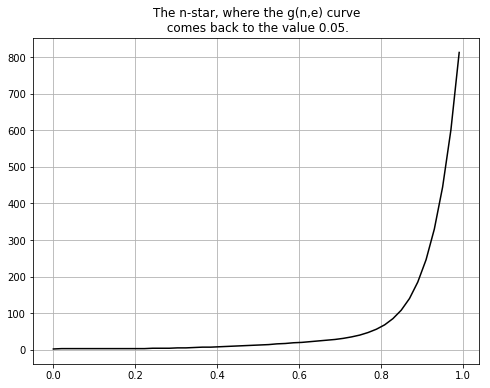

In [11]:
print('n-star(ecc) comes from a fit done in mathematica, see gwtools.py, aNmax(ecc) function.')
ecc = np.linspace(0., 0.99, 50)
nstar = [ gwt.aNmax(uu) for uu in ecc ]
plt.figure( figsize=(8,6) )
plt.plot(ecc, nstar, 'k-')
plt.title('The n-star, where the g(n,e) curve\n comes back to the value 0.05.');
plt.grid(True)

### Check the above function for some eccentricity by plotting $g(n,e)$ versus $0.05$ . 

For example, look at the g(n,e) curve for ecc =  0.9
The n-star is  216.0
max is  17.395364810603994


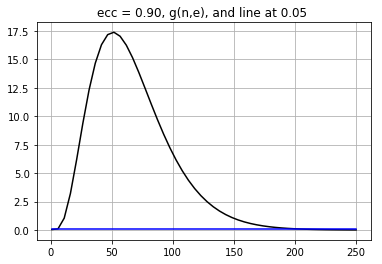

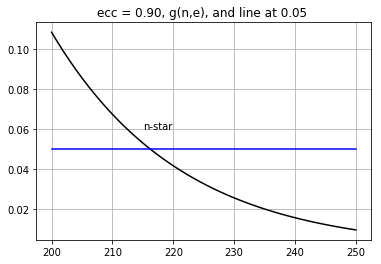

In [12]:
ecc = 0.9 # Eccentricity
print('For example, look at the g(n,e) curve for ecc = ', ecc)
print('The n-star is ', gwt.aNmax(ecc) )
#
# full g(n,e) curve
#
mmin = 1
mmax = 250
modes = np.linspace(mmin,mmax,50)
gne = gwt.ggSimp(modes, ecc)

plt.plot(modes, gne, 'k-')
# The line at 1/20th max is...
yval = 0.05
print('max is ', np.max( gne ) )

plt.plot( [mmin, mmax], [yval, yval], 'b-')
plt.grid(True)
plt.title('ecc = %.2f, g(n,e), and line at 0.05 '%(ecc) )
plt.show()
#
# close up
#
mmin = 200
mmax = 250
modes = np.linspace(mmin,mmax,50)
gne = gwt.ggSimp(modes, ecc)

plt.plot(modes, gne, 'k-')
plt.grid(True)
# The line at 1/20th max is...
yval = 0.05

plt.plot( [mmin, mmax], [yval, yval], 'b-')
plt.title('ecc = %.2f, g(n,e), and line at 0.05 '%(ecc) )
plt.text(215,0.06,'n-star');

## Create a numpy array of GW strain amplitudes for that planet and append to the table.

Using the formula from Amaro-Seoane et al. reference, Eqn. (9)
$$ h_{n} = 2 \sqrt{\frac{32}{5}} \frac{ {\frak M}^{5/3} }{{\mathbf n}\,d_{L}} \big( 2\pi f_{r} \big) \sqrt{ \mathbf {g(n,e)} }$$
where $e$ is the eccentricity, $n$ is the mode number, ${\frak M}$ is the chirp mass $M_{1}^{3/5}M_{2}^{3/5}/(M_{1}+M_{2})^{1/5}$, $d = d_{L}/(1+z)$, and $f_{r}$ is the orbital frequency, so the mode frequency is $f = f_{r}\,n$ for $n=(1,2,3...)$.  I like the chirp mass as $\mu^{3/5} M^{2/5}$ with reduced mass $\mu$ and total mass $M$ for the binary.

The above is found in gwtools.py as  hh(nn, ee, m1, m2, a, dL).

Does not render the above perfectly.  Looks like a font problem on the square root.  Otherwise okay.

In [13]:
help(gwt.hh)  # Start using the gwt.hh function below!!!
help(gwt.orbitalFreq)
help(gwt.hhModes)  # Use this one!!!

Help on function hh in module gwTools:

hh(nn, ee, m1, m2, a, dL)
    From Amaro-Seoane et al. 2010, the GW amplitude for GW mode nn in units of
    the orbital frequency, eccentricity ee, binary masses m1 and m2, 
    semi-major axis a, and distance to source dL.  Use SI units.
    Returns the GW amplitude for that frequency mode.
    Amaro-Seoane et al. Eqn. (9), refs Finn and Thorne 2000.

Help on function orbitalFreq in module gwTools:

orbitalFreq(m1, m2, a)
    Given two masses, m1 and m2, and the semimajor axis a,
    return the orbital frequency in Hz from Kepler relations.

Help on function hhModes in module gwTools:

hhModes(ee, m1, m2, a, dL, freq=0)
    From Amaro-Seoane et al. 2010, the GW amplitude for eccentricity ee, 
    binary masses m1 and m2, semi-major axis a, and distance to source dL.  Use SI units.
    If freq is zero, use Kepler and a to find the orbital period.
    Returns the tuple of (modes, GW amplitudes for those frequency modes).
    Amaro-Seoane et al. E

In [14]:
aData.head(2)  # To see the headers:)  Just a reminder.

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx
0,HD 142022 A,b,Radial Velocity,1928.0,2.93,0.5300,4.44,35.87,0.9,2018-04-26,27.88
1,HD 39091,b,Radial Velocity,2151.0,3.38,0.6405,10.27,18.21,1.1,2014-07-23,54.92


### Explicitly use Amaro-Seoane et al. Eqn (9), so that we can see it.  Do NOT use gwt.hh().  Note the physical constants are back, $G^{5/3}/c^{4}$ to make it dimensionless when we use SI units for all the other parameters.

In [15]:
# Actually append n_min, n_max, numpy array of GW strains h.
# In the Mathematica JustStrainPlots.nb, about 40% down, calc hhVfreq first time.

hhmodesCol = []  # Setup a list of the hhmodes that will be appended to the dataframe.
modesCol = []    # The modes set acually used for the calculation, int(modeMin) to int(modeMax)+1
freq0Col = []    # Collect the orbital frequency that was used.

for irow in range(len(aData)):
    # Calculate the SI parameters needed by the strains and the strain "front coefficient."
    
    orbeccen = aData['pl_orbeccen'].values[irow]
    modeMax = gwt.aNmax( orbeccen )  # The "max" mode number where g(n,e) returns to 1/20th its peak value.
    modeMin = gwt.aNmin( orbeccen )  # Either 1 for e>0 or 2 for e=0.
    #
    m1 = aData['pl_bmassj'].values[irow]*massJ
    m2 = aData['st_mass'].values[irow]*massSun
    smax = aData['pl_orbsmax'].values[irow]*au
    dL = aData['st_dist'].values[irow]*pc
    freq0 = 1.0/( aData['pl_orbper'].values[irow]*secsDay )
    # Amaro-Seoane Eqn. (9)...common terms.
    #frontCoeff = np.power(bigG,5/3.)/cee**4 * 2 * np.sqrt(32/5.) * np.power( gwt.chirpM(m1,m2), 5/3.)*\
    #np.power((2*np.pi*freq0), 2/3.)/dL
    #if irow > 6 and irow < 10:
    #    print('irow is ', irow, ' ,frontCoeff is ', frontCoeff, ' pl_orbeccen is ', orbeccen)

    # Now loop over the GW modes and calc the dim-less strain and the modes used.
    #hhmodes = [ frontCoeff* np.sqrt( gwt.ggSimp(uu, orbeccen) )/uu for uu in range(int(modeMin), int(modeMax)+1)  ]
    #modes = [ uu for uu in range(int(modeMin), int(modeMax)+1)  ]
    
    (modes, hhmodes) = gwt.hhModes(orbeccen, m1, m2, smax, dL, freq0)
    
    # Append to the list.
    hhmodesCol.append( hhmodes )
    modesCol.append( modes )
    freq0Col.append( freq0 )
        

In [16]:
# Check there is stuff in there.
print( len(hhmodesCol[0] ) )
print( hhmodesCol[0] )
print( modesCol[0] )

15
[1.5281102106867083e-26, 1.7763165764544123e-26, 2.3548627071952827e-26, 2.1773193163600543e-26, 1.7922738765887217e-26, 1.3946477857123884e-26, 1.0502509222550448e-26, 7.742252737168713e-27, 5.623020198670333e-27, 4.039285266798353e-27, 2.8773204372132183e-27, 2.036056203803398e-27, 1.4330471615543017e-27, 1.0041733005437975e-27, 7.010432246442409e-28]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [17]:
#Append the hhmodesCol to the dataframe, for ease of getting at the other attributes.
aData['freq0'] = freq0Col
aData['modes'] = modesCol
aData['hhmodes'] = hhmodesCol

In [18]:
# Check that appending happened correctly.
aData.head(3)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx,freq0,modes,hhmodes
0,HD 142022 A,b,Radial Velocity,1928.0,2.93,0.5300,4.44,35.87,0.90,2018-04-26,27.88,6.003150e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.5281102106867083e-26, 1.7763165764544123e-2..."
1,HD 39091,b,Radial Velocity,2151.0,3.38,0.6405,10.27,18.21,1.10,2014-07-23,54.92,5.380788e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[8.230508420052954e-26, 4.507375225359441e-26,..."
2,HD 137388 A,b,Radial Velocity,330.0,0.89,0.3600,0.20,38.45,0.68,2018-04-26,26.01,3.507295e-08,"[1, 2, 3, 4, 5, 6, 7]","[1.2823088785829818e-27, 3.436828702043515e-27..."


### Make a plot of some high eccentricity planet and the modes to double check.

In [19]:
aDataEccen = aData.sort_values(by = 'pl_orbeccen', ascending = False)
aDataEccen.head(3)  #  Looks like Row 304 has eccen 0.9560 and a ton of modes.

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx,freq0,modes,hhmodes
309,HD 20782,b,Radial Velocity,591.90002,1.370,0.970,1.95,35.50,1.07,2018-04-26,NaN,1.955410e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.7836141610501347e-26, 1.315076514552221e-26..."
199,HD 4113,b,Radial Velocity,526.62000,1.280,0.903,1.56,44.05,0.99,2014-12-03,22.7,2.197804e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.2594583314652946e-26, 7.233458381856687e-27..."
23,HD 76920,b,Radial Velocity,415.40000,1.149,0.856,3.93,184.80,1.17,2017-11-30,NaN,2.786248e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.0138731199811866e-26, 4.557659817080447e-27..."


In [20]:
irowBig = aDataEccen.index[0]
print(irowBig)

309


51140161.728
603    HD 20782


Text(0.5,1,'h modes for planet on star HD 20782 with e = 0.970')

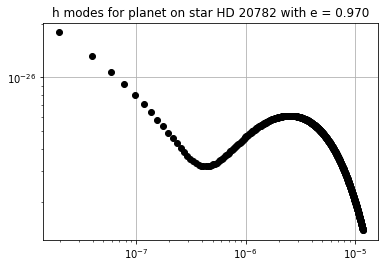

In [21]:
#  Looks like Row 304 has eccen 0.9560 and a ton of modes.
#  Or row 0 of the new dataframe.
#irowBig = 309  # index in dataframe, also the same index for aDataEccen.
print(  aData['pl_orbper'][irowBig]*secsDay )
freq0 = 1.0/( aData['pl_orbper'][irowBig]*secsDay )


xx = np.array(aData['modes'][irowBig]) * freq0
#  Needed the np.array() or saw an error that my list was not AN integer!!
yy = aData['hhmodes'][irowBig]
print( len(xx), '  ', aData['pl_hostname'][irowBig] )

# Plot xx and yy for ONE planet with crazy high eccentricity.
plt.loglog(xx, yy, 'ko')
plt.grid(True)
plt.title('h modes for planet on star %s with e = %.3f' % ( aData['pl_hostname'][irowBig], aData['pl_orbeccen'][irowBig] ) )

### The above looks weird, double check versus the $\sqrt{g(n,e)}/n$ .

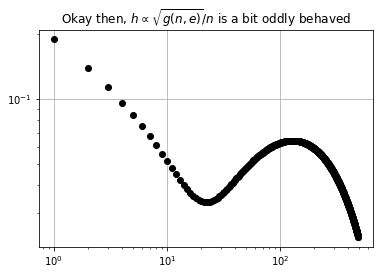

In [22]:
# Above is weird!!
eccen = aData['pl_orbeccen'][irowBig]
xx = np.array( range(1,491) )
yy = [ np.sqrt( gwt.ggSimp(nn, eccen) )/nn for nn in xx ]
plt.loglog(xx, yy, 'ko')
plt.title('Okay then, $h\propto \sqrt{g(n,e)}/n$ is a bit oddly behaved')
plt.grid(True)
# Okay not so weird!!

## Plot All the dimensionless strains for the exops (different colors eventually)
### Replace with a density plot of some kind?

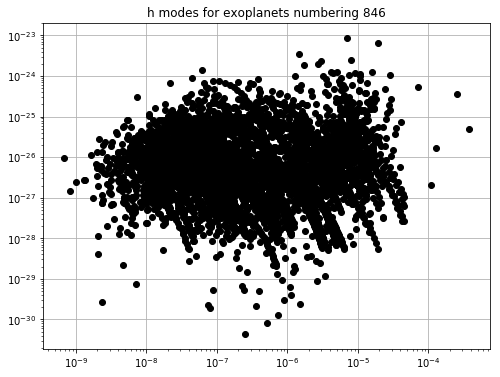

In [23]:
#from matplotlib import cm # for colormap need max number of planets
#myCmap = cm.get_cmap('cool')

#maxNum = len(aData)

# Loop over rows seems easiest.
figAll = plt.figure( figsize=(8,6) )
axAll = figAll.add_subplot((111))

# Seeing other ways to loop over rows, more standard?  .iterrows or .itertuple
for irow in range( len(aData) ):  #  range(4):  # cannot iterate over length, .itertuples() 

    freq0 = 1.0/( aData['pl_orbper'].values[irow]*secsDay )
    xx = np.array( aData['modes'].values[irow] ) * freq0
    #  Needed the np.array() or saw an error that my list was not AN integer!!
    yy = np.array( aData['hhmodes'].values[irow] )

    # Plot xx and yy for ONE planet with crazy high eccentricity.
    #myCmap = plt.colormaps('cool')
    #axAll = plt.loglog(xx, yy, c=0.44, cmap=myCmap)
    axAll.loglog(xx, yy, 'ko')

#plt.colorbar(True)
plt.grid(True)
plt.title('h modes for exoplanets numbering %d' % len(aData) );

## The Noise curve from Shane *Larson* at CalTech, url below.
## Use the downloaded data that is Amplitude Spectral Density (ASD), and for freq plot want it in dimless strain units (1 year or 4 years) by dividing by sqrt(Int Time), for the SNR need the $S_n(f)$ in per Hz, the Power Spectral Density (PSD) of the expected noise.  

## For the future use the Cornish-Robson noise curve as standard, definitely compare.

The Larson curve from http://www.srl.caltech.edu/~shane/sensitivity/MakeCurve.html .

In [24]:
# Load one or other of the Larson curves into a Panda Dataframe.
larsonASDFile = 'scg_5597_2W_2p5e9m.dat'  # Amplitude Spectral Densities, ASD's in per root Hz!!!
larsonASD = pd.read_csv( thisDir + '/' + larsonASDFile, header=None, delim_whitespace=True, \
                               names=['freq[Hz]', 'ASD[Hz^-1/2]'], skiprows=22 )
larsonASD.head(3)

,freq[Hz],ASD[Hz^-1/2]
0,1.953007e-07,4.115269e-12
1,1.998512e-07,3.929997e-12
2,2.045077e-07,3.753070e-12


In [25]:
# Append the 1 year integrated dimension-less by dividing ASD by sqrt(1 year in secs).  Check this!!
larsonASD['h[dimless,4yr]'] = larsonASD['ASD[Hz^-1/2]'].values/np.sqrt(4.0*secsYear)

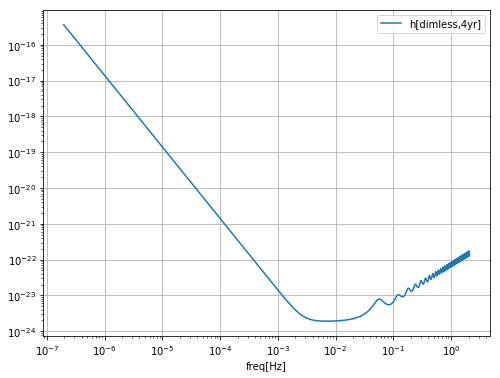

In [26]:
larsonASD.plot(x = 'freq[Hz]', y = 'h[dimless,4yr]', logy=True, logx=True, grid=True, figsize=(8,6) )

## The 4 year Larson curve and the individual modes for each exoplanet.

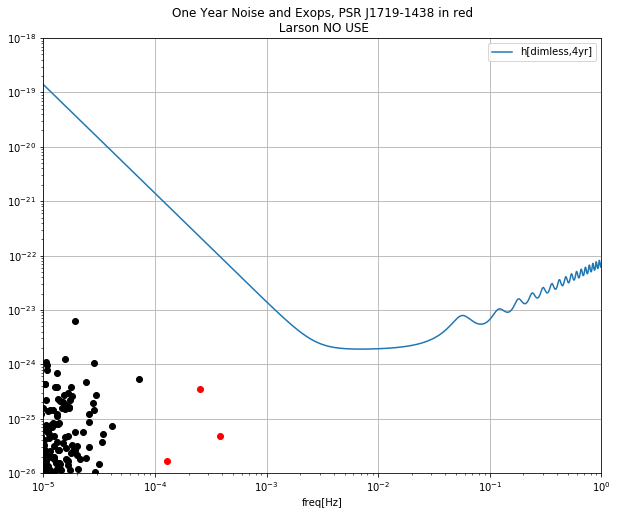

In [27]:
# plotting different dataframes in same plot

ax = larsonASD.plot(x = 'freq[Hz]', y = 'h[dimless,4yr]', logy=True, logx=True, grid=True, figsize=(10,8) )
for irow in range(len(aData)):
    aa = aData['freq0'].values[irow]
    xx = [aa * uu for uu in aData['modes'].values[irow]  ] 
    yy = aData['hhmodes'].values[irow]
    acolor = 'ko'
    if aData['pl_hostname'].values[irow] == 'PSR J1719-1438':  # Flag the brightest one with red dots.
        if aData['pl_letter'].values[irow] == 'b':
            acolor = 'ro'
    ax.plot( xx, yy, acolor)
    ax.set_ylim((1e-26, 1e-18) )
    ax.set_xlim((1e-5, 1.0) )
    ax.set_title('One Year Noise and Exops, PSR J1719-1438 in red\n Larson NO USE');
    

In [28]:
# Print the row for exop ...
for irow in range(len(aData) ):
    if aData['pl_hostname'].values[irow] == 'PSR J1719-1438' and \
    aData['pl_letter'].values[irow] == 'b':
        theRow = irow
        print( aData.values[irow] )

['PSR J1719-1438' 'b' 'Pulsar Timing' 0.09070629 0.0044 0.06 1.2 1200.0
 1.4 '2014-05-14' nan 0.0001275994649772808 list([1, 2, 3])
 list([1.681497004686017e-26, 3.5797366388109786e-25, 4.8348526229385945e-26])]


In [29]:
gwt.aNmax(0.06)  # If e>0 always have at least three modes, n = 1,2,3 .

3.0

# Do not use Larson for noise, use Cornish and Robson, interpolator in gwTools.py

## Cornish and Robson noise curve, see the paper arXiv https://arxiv.org/pdf/1803.01944.pdf

Coded into gwt.lisa_psd() by Katie and does NOT have the white dwarf confusion noise in it...which is the way we want it, I think.  Use all aData as it is here, with SNR from Larson S_n(f).

In [30]:
help(gwt.lisa_psd)

Help on function lisa_psd in module gwTools:

lisa_psd()
    Computes LISA sensitivity curve according to `Cornish and Robson 2018 <https://arxiv.org/pdf/1803.01944.pdf>`_ Their Eqn. (1) and (10) for P_oms (optical metrology noise) and (11) P_acc (test mass acceleration noise). Does NOT include S_c the confusion noise from white dwarf binaries.
    Returns an interpolating function for S_n() which has units "per Hz," so use result(my number) to call the function.  The frequency must be between 1e-9 and 10 Hz.



## Plot Larson and C&R for 4 years.

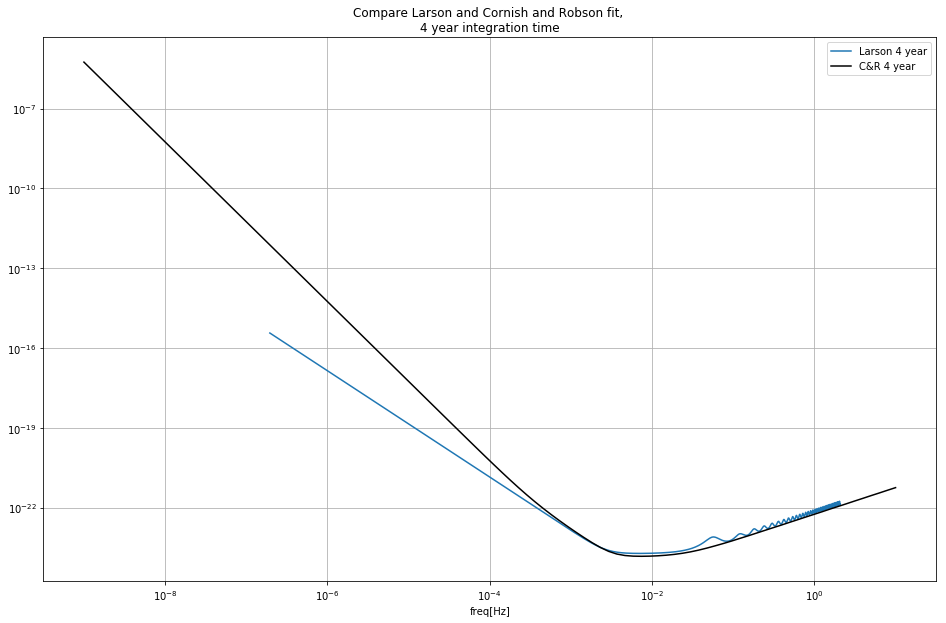

In [31]:
# Compare Larson 4 year and C&R 4 year dimless noise.  NO sky or polarization factor, NO \cal R function.
ax = larsonASD.plot(x = 'freq[Hz]', y = 'h[dimless,4yr]', logy=True, logx=True, grid=True, figsize=(16,10), 
                    label='Larson 4 year')
xx = np.logspace(-9,1,100)
SnCR = gwt.lisa_psd() # per Hz
yy = SnCR(xx)
yy = np.sqrt(yy/(4.0*secsYear) )

ax.plot(xx, yy, 'k-', label='C&R 4 year')
ax.set_title('Compare Larson and Cornish and Robson fit, \n4 year integration time')
ax.legend();

## Setup, copying from PrettyPlotsGWStrainEtc the rcparams for poster/presentation plots (not yet paper plots)

In [32]:
# copy over the plot rcparmas from PrettyPlotsGWStrain...

# Plot defaults.
params = {'font.size': 24.0,
          'legend.fontsize': 'x-large',
          'figure.figsize': (16, 10),  # (14,10)
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
#aa = 18.0
#params = {'legend.fontsize': aa,
#          'figure.figsize': (14, 10),
#         'axes.labelsize': aa,
#         'axes.titlesize': aa,
#         'xtick.labelsize': aa,
#         'ytick.labelsize': aa}
plt.rcParams.update(params)
#print(mpl.rcParams)
savePlot = True

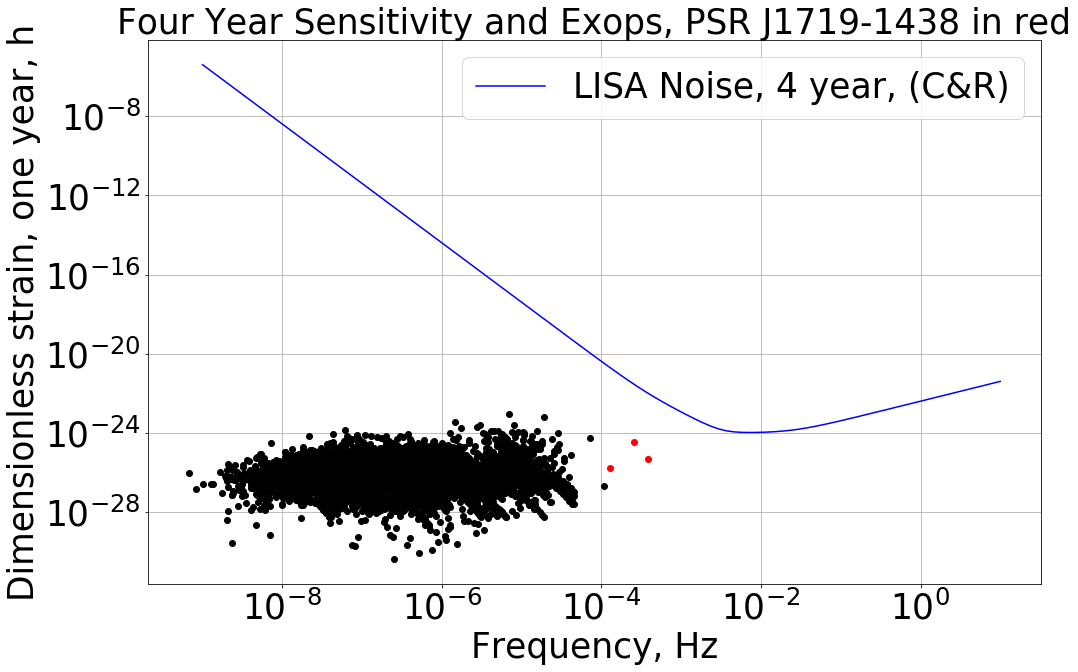

In [33]:
# plotting
afig = plt.figure()
ax= afig.add_subplot((111))

ff = np.logspace(-9,1,100)
SnCR = gwt.lisa_psd()
y1 = SnCR(ff)
y2 = np.sqrt(y1)/np.sqrt(4.0*secsYear*2)  # C&R would have this be all the SNR formula EXCEPT some collection of 
# the numerator, so tempted to put  sqrt(y1)/sqrt(4*secsyear*2) , extra two from the top

ax.plot(ff, y2, 'b-', label='LISA Noise, 4 year, (C&R)')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Four Year Sensitivity and Exops, PSR J1719-1438 in red')
ax.set_xlabel('Frequency, Hz')
ax.set_ylabel('Dimensionless strain, one year, h')

for irow in range(len(aData)):
    aa = aData['freq0'].values[irow]
    xx = [aa * uu for uu in aData['modes'].values[irow]  ] 
    yy = aData['hhmodes'].values[irow]
    acolor = 'ko'
    if aData['pl_hostname'].values[irow] == 'PSR J1719-1438':  # Flag the brightest one with red dots.
        if aData['pl_letter'].values[irow] == 'b':
            acolor = 'ro'
    ax.plot( xx, yy, acolor)  # , label = 'Exop Modes' Cannot use label because so many plot statements.
    #ax.set_ylim((1e-26, 1e-18) )
    #ax.set_xlim((1e-5, 1.0) )
    #ax.set_title('One Year Noise and Exops, PSR J1719-1438 in red');
    
plt.grid(True)
plt.legend();


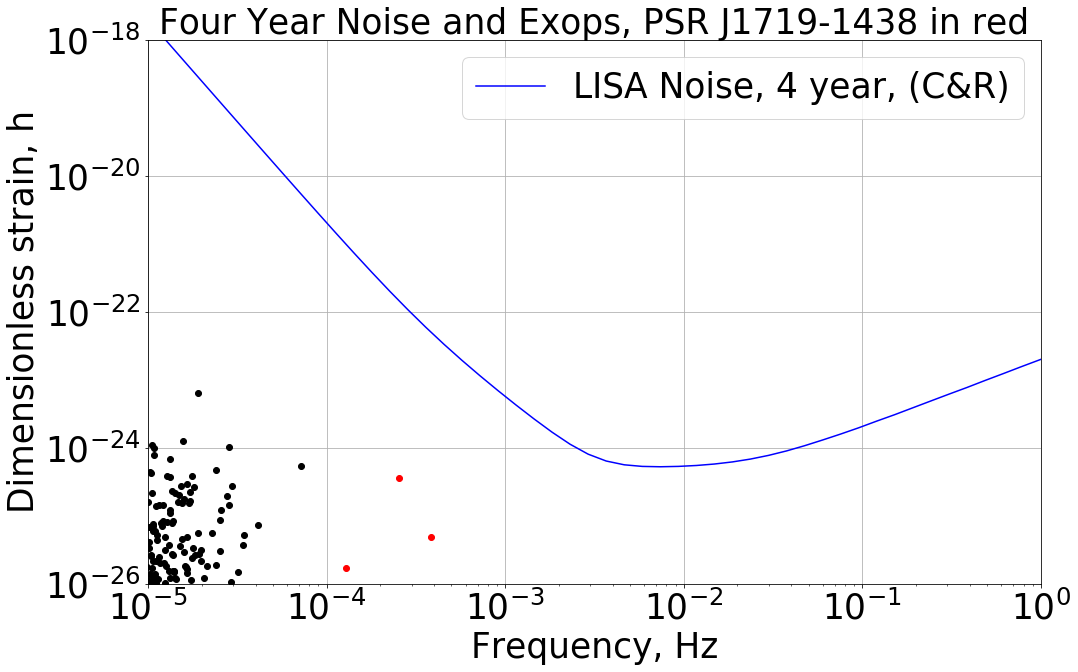

In [34]:
# Plot the exop modes vs sqrt(S_n/(Tint*2) )


afig = plt.figure( figsize=(16,10) )
ax= afig.add_subplot((111))

ff = np.logspace(-9,1,100)
SnCR = gwt.lisa_psd()
y1 = SnCR(ff)
y2 = np.sqrt(y1)/np.sqrt(4.0*secsYear*2)

ax.plot(ff, y2/2.0, 'b-', label='LISA Noise, 4 year, (C&R)')

ax.set_xscale('log')
ax.set_yscale('log')
plt.grid(True)
plt.legend()

ax.set_title('Four Year Noise and Exops, PSR J1719-1438 in red')
ax.set_xlabel('Frequency, Hz')
ax.set_ylabel('Dimensionless strain, h')

for irow in range(len(aData)):
    aa = aData['freq0'].values[irow]
    xx = [aa * uu for uu in aData['modes'].values[irow]  ] 
    yy = aData['hhmodes'].values[irow]
    acolor = 'ko'
    if aData['pl_hostname'].values[irow] == 'PSR J1719-1438':  # Flag the brightest one with red dots.
        if aData['pl_letter'].values[irow] == 'b':
            acolor = 'ro'
    ax.plot( xx, yy, acolor)
    ax.set_ylim((1e-26, 1e-18) )
    ax.set_xlim((1e-5, 1.0) )
    #ax.set_title('One Year Noise and Exops, PSR J1719-1438 in red');
    
if savePlot:
    #plt.savefig('../poster/pix/plot_g_n_e.eps')  # Both eps and svg seem to make good PDFs of poster.
    plt.savefig('../poster/pix/plot_hexopVSrootSn.png')
    plt.savefig('../poster/pix/plot_hexopVSrootSn.svg')

## Calculate the signal-to-noise ratio for each planet.  From matched filtering us $\frac{S}{N}\big)^2 = 2 T \sum_{m=1}^\infty \frac{|h(m f_0)|^2}{S_n(m f_0)}$ , $T$ is integration time, $h$ are the source dimless strains at freq $m f_0$ where $f_0$ is the orbital frequency, and the sum below is truncated at n-star(eccentricity) not $\infty$ .  Cornish & Robson would have $4 T$ in above and they talk alot about 2 channels or three and the $\cal R$ function.  Maggiore would have $2 T$.  More Factors to figure out.

In [35]:
# Do the sum over modes for each exop and append to the dataframe eventually.

allSNR = []
snCR = gwt.lisa_sn  # Cornish and Robson function, includes the \cal R factor.

for irow in range(len(aData)):
    freq0 = aData['freq0'].values[irow]
    modes = np.array( aData['modes'].values[irow] ) # Make sure they are numpy arrays!
    hhmodes = np.array( aData['hhmodes'].values[irow] )
    
    snrsq = 0.0
    for amode, hhmode in zip(modes,hhmodes):
        snrsq += hhmode**2/snCR(freq0*amode)  # Wanted the function, some of the exop freqs are very low!
        
    # 4.0 years!
    snr = np.sqrt( 4.0*secsYear*2 * snrsq)
    allSNR.append( snr )
    
print('len(allSNR) is ',len(allSNR))

len(allSNR) is  846


In [36]:
# append to aData dataframe
aData['SNR'] = allSNR
aData.head(4)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx,freq0,modes,hhmodes,SNR
0,HD 142022 A,b,Radial Velocity,1928.00,2.93,0.5300,4.44,35.87,0.90,2018-04-26,27.88,6.003150e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.5281102106867083e-26, 1.7763165764544123e-2...",6.204064e-16
1,HD 39091,b,Radial Velocity,2151.00,3.38,0.6405,10.27,18.21,1.10,2014-07-23,54.92,5.380788e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[8.230508420052954e-26, 4.507375225359441e-26,...",8.208591e-15
2,HD 137388 A,b,Radial Velocity,330.00,0.89,0.3600,0.20,38.45,0.68,2018-04-26,26.01,3.507295e-08,"[1, 2, 3, 4, 5, 6, 7]","[1.2823088785829818e-27, 3.436828702043515e-27...",2.718871e-15
3,GJ 3021,b,Radial Velocity,133.71,0.49,0.5110,3.37,17.62,0.90,2014-05-14,56.76,8.656102e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1.3652330108272753e-25, 1.7627728192177104e-2...",1.393708e-11


## Create a dataframe ordered by SNR.

In [37]:
bData = aData.sort_values(by = 'SNR', ascending = False)
bData.head(3)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx,freq0,modes,hhmodes,SNR
504,PSR J1719-1438,b,Pulsar Timing,0.090706,0.00440,0.0600,1.2000,1200.0,1.40,2014-05-14,NaN,0.000128,"[1, 2, 3]","[1.681497004686017e-26, 3.5797366388109786e-25...",0.001331
343,PSR J2322-2650,b,Pulsar Timing,0.322964,0.01020,0.0017,0.7949,230.0,1.40,2017-12-21,4.4,0.000036,"[1, 2, 3]","[7.075677179501135e-28, 5.354424563392014e-25,...",0.000049
1477,KELT-1,b,Transit,1.217514,0.02466,0.0099,27.2300,262.0,1.32,2014-05-14,NaN,0.000010,"[1, 2, 3]","[4.887383856587412e-26, 6.3500670996228055e-24...",0.000011


## Print the table or SNR and other items.

In [38]:
astr = 'name                \teccen\tper(days)\tSNR\tindex\n'
print(astr)
for ii in range(16):
    astr = '%-20s\t%6.4f\t%.3f\t%.3g\t%d'%\
    (bData['pl_hostname'].values[ii]+' '+bData['pl_letter'].values[ii], bData['pl_orbeccen'].values[ii], 
     bData['pl_orbper'].values[ii], 
     bData['SNR'].values[ii], ii)
    print(astr)

name                	eccen	per(days)	SNR	index

PSR J1719-1438 b    	0.0600	0.091	0.00133	0
PSR J2322-2650 b    	0.0017	0.323	4.9e-05	1
KELT-1 b            	0.0099	1.218	1.11e-05	2
WASP-43 b           	0.0000	0.813	6.01e-06	3
WASP-19 b           	0.0020	0.789	1.73e-06	4
HATS-18 b           	0.1660	0.838	1.65e-06	5
KELT-16 b           	0.0000	0.969	1.62e-06	6
KELT-9 b            	0.0000	1.481	1.22e-06	7
HATS-24 b           	0.2420	1.348	8.02e-07	8
tau Boo b           	0.0110	3.312	7.64e-07	9
TrES-3 b            	0.0000	1.306	5.47e-07	10
HATS-52 b           	0.2460	1.367	5.44e-07	11
CoRoT-2 b           	0.0143	1.743	4.04e-07	12
WASP-121 b          	0.0000	1.275	4.01e-07	13
HD 143105 b         	0.0700	2.197	3.73e-07	14
WASP-135 b          	0.0000	1.401	3.31e-07	15


In [39]:
# output top few SNRs to csv file
bData[0:11].to_csv('../poster/pix/SNRs.csv', columns=['pl_hostname', 'pl_orbeccen', 'pl_orbper', 'SNR'],
                  float_format = '%6.4g')

## Exops with the highest eccentricity

In [40]:
cData = aData.sort_values(by = 'pl_orbeccen', ascending = False)
cData.head(6)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx,freq0,modes,hhmodes,SNR
309,HD 20782,b,Radial Velocity,591.90002,1.370,0.970,1.95,35.50,1.07,2018-04-26,NaN,1.955410e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.7836141610501347e-26, 1.315076514552221e-26...",7.861450e-09
199,HD 4113,b,Radial Velocity,526.62000,1.280,0.903,1.56,44.05,0.99,2014-12-03,22.70,2.197804e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.2594583314652946e-26, 7.233458381856687e-27...",5.270458e-11
23,HD 76920,b,Radial Velocity,415.40000,1.149,0.856,3.93,184.80,1.17,2017-11-30,NaN,2.786248e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.0138731199811866e-26, 4.557659817080447e-27...",1.248293e-11
401,HD 98649,b,Radial Velocity,4951.00000,5.600,0.850,6.80,42.77,1.00,2014-05-14,23.38,2.337725e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.3095832207217623e-26, 5.675932575080468e-27...",7.776333e-15
455,HD 156846,b,Radial Velocity,359.51001,1.120,0.850,10.67,49.00,1.38,2018-04-26,20.41,3.219402e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.2769619316582374e-25, 5.534546953833175e-26...",1.980423e-10
12,HD 108341,b,Radial Velocity,1129.00000,2.000,0.850,3.50,49.40,0.84,2015-01-08,20.23,1.025162e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.3931095245605775e-26, 6.037948261699841e-27...",6.976269e-13


In [41]:
import sys
print( sys.version )

3.6.6 (default, Jul 19 2018, 14:25:17) 
[GCC 8.1.1 20180712 (Red Hat 8.1.1-5)]
